In [2]:
import os
import random
import time
import gc
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, cohen_kappa_score

import timm
import xgboost as xgb
import joblib
from skimage.feature import hog as skhog

# reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)
if DEVICE.type == "cuda":
    try:
        print("GPU:", torch.cuda.get_device_name(0))
    except:
        pass


Device: cuda
GPU: Tesla T4


In [3]:
# CELL 2 — Paths & CSVs
DATA_PATH = '/kaggle/input/rsna-bone-age'  # Kaggle dataset path

train_csv = pd.read_csv(os.path.join(DATA_PATH, 'boneage-training-dataset.csv'))
test_csv  = pd.read_csv(os.path.join(DATA_PATH, 'boneage-test-dataset.csv'))

train_img_path = os.path.join(DATA_PATH, 'boneage-training-dataset', 'boneage-training-dataset')
test_img_path  = os.path.join(DATA_PATH, 'boneage-test-dataset', 'boneage-test-dataset')

print("train_csv:", train_csv.shape)
print("test_csv :", test_csv.shape)
print("train_img_path:", train_img_path)
print("test_img_path :", test_img_path)


train_csv: (12611, 3)
test_csv : (200, 2)
train_img_path: /kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset
test_img_path : /kaggle/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset


In [4]:
# CELL 3 — Prepare DataFrame & splits
df = train_csv.copy()
df['boneage_months'] = df['boneage']
# Kaggle training csv has 'male' column (1 if male else 0)
if 'male' in df.columns:
    df['sex_int'] = df['male'].astype(int)
elif 'sex' in df.columns:
    df['sex_int'] = df['sex'].map({'M':1,'F':0}).astype(int)
else:
    raise RuntimeError("No sex column found")

# stratified split by sex
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df['sex_int'])
val_df, test_df   = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df['sex_int'])

print("Counts -> Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


Counts -> Train: 8827 Val: 1892 Test: 1892


In [ ]:
# CELL 4 — ROI contrast stretching + HOG utilities
def roi_contrast_stretch_gray(img):
    # img: grayscale uint8
    try:
        _, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        coords = np.column_stack(np.where(mask > 0))
        if coords.size == 0:
            return img
        y1, x1 = coords.min(axis=0)
        y2, x2 = coords.max(axis=0)
        roi = img[y1:y2+1, x1:x2+1]
        if roi.size == 0:
            return img
        pmin, pmax = np.percentile(roi, (1, 99))
        if pmax - pmin < 1e-6:
            return img
        roi2 = np.clip((roi - pmin) * (255.0 / (pmax - pmin)), 0, 255).astype(np.uint8)
        out = img.copy()
        out[y1:y2+1, x1:x2+1] = roi2
        return out
    except Exception:
        return img

def extract_hog_features(img_path, resize=(256,256), pixels_per_cell=(8,8), cells_per_block=(2,2), orientations=9):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(img_path)
    img = roi_contrast_stretch_gray(img)
    img = cv2.resize(img, resize)
    feat = skhog(img, orientations=orientations, pixels_per_cell=pixels_per_cell,
                 cells_per_block=cells_per_block, feature_vector=True)
    return feat

In [6]:
# CELL 5 — Build HOG datasets & scale (baseline)
# Note: for speed we limit samples. Remove max_samples to use full dataset.
def build_hog_dataset(df_in, img_dir, max_samples=None):
    X, y = [], []
    it = df_in.reset_index(drop=True)
    if max_samples:
        it = it.iloc[:max_samples]
    for _, row in tqdm(it.iterrows(), total=len(it), desc="HOG build"):
        img_id = int(row['id'])
        p = os.path.join(img_dir, f"{img_id}.png")
        try:
            feat = extract_hog_features(p, resize=(256,256))
        except FileNotFoundError:
            continue
        feat2 = np.concatenate([feat, np.array([row['sex_int']], dtype=np.float32)])
        X.append(feat2)
        y.append(row['boneage_months'])
    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

# build with modest size to run quickly on Kaggle; set None to use all
X_train_hog, y_train_hog = build_hog_dataset(train_df, train_img_path, max_samples=8000)
X_val_hog,   y_val_hog   = build_hog_dataset(val_df,   train_img_path, max_samples=2000)

print("HOG shapes:", X_train_hog.shape, X_val_hog.shape)

scaler_hog = PowerTransformer()
X_train_hog_s = scaler_hog.fit_transform(X_train_hog)
X_val_hog_s   = scaler_hog.transform(X_val_hog)

# save scaler (optional)
joblib.dump(scaler_hog, "scaler_hog.joblib")

HOG build:   0%|          | 0/8000 [00:00<?, ?it/s]

HOG build:   0%|          | 0/1892 [00:00<?, ?it/s]

HOG shapes: (8000, 34597) (1892, 34597)


['scaler_hog.joblib']

In [ ]:
# CELL 6 — Train XGBoost regressor (HOG baseline)
xgb_reg = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    tree_method='gpu_hist' if torch.cuda.is_available() else 'hist',
    random_state=42,
    verbosity=1
)

xgb_reg.fit(
    X_train_hog_s, y_train_hog,
    eval_set=[(X_val_hog_s, y_val_hog)],
    early_stopping_rounds=50,
    verbose=50
)

y_val_pred_hog = xgb_reg.predict(X_val_hog_s)
mae_hog = mean_absolute_error(y_val_hog, y_val_pred_hog)
rmse_hog = mean_squared_error(y_val_hog, y_val_pred_hog, squared=False)
r2_hog = r2_score(y_val_hog, y_val_pred_hog)
print("HOG+XGB Val -> MAE: %.4f months | RMSE: %.4f | R2: %.4f" % (mae_hog, rmse_hog, r2_hog))

joblib.dump(xgb_reg, "xgb_hog_regressor.joblib")


[0]	validation_0-rmse:42.91394
[50]	validation_0-rmse:36.06832
[100]	validation_0-rmse:33.62253
[150]	validation_0-rmse:32.31020
[200]	validation_0-rmse:31.62669
[250]	validation_0-rmse:31.16732
[300]	validation_0-rmse:30.92033
[350]	validation_0-rmse:30.74866
[400]	validation_0-rmse:30.62890
[450]	validation_0-rmse:30.53920
[500]	validation_0-rmse:30.48244
[550]	validation_0-rmse:30.44297
[600]	validation_0-rmse:30.41218
[650]	validation_0-rmse:30.39527
[700]	validation_0-rmse:30.37821
[750]	validation_0-rmse:30.36801
[800]	validation_0-rmse:30.36024
[850]	validation_0-rmse:30.35170
[900]	validation_0-rmse:30.34845
[950]	validation_0-rmse:30.34479
[999]	validation_0-rmse:30.34198
HOG+XGB Val -> MAE: 23.7306 months | RMSE: 30.3416 | R2: 0.5067


['xgb_hog_regressor.joblib']

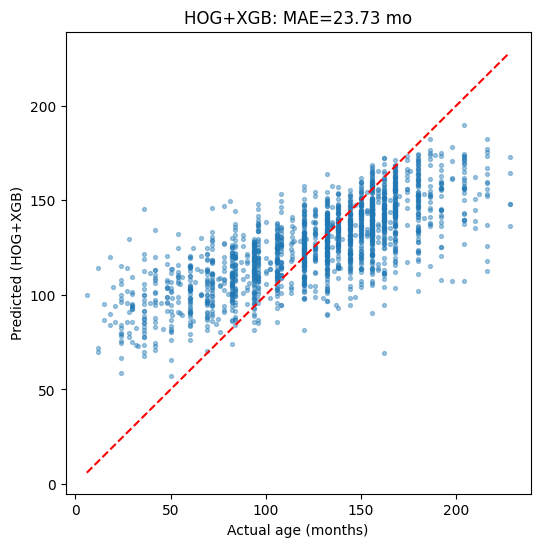

In [8]:
# CELL 7 — HOG baseline scatter
plt.figure(figsize=(6,6))
plt.scatter(y_val_hog, y_val_pred_hog, alpha=0.4, s=8)
mn, mx = min(y_val_hog.min(), y_val_pred_hog.min()), max(y_val_hog.max(), y_val_pred_hog.max())
plt.plot([mn,mx],[mn,mx],'r--')
plt.xlabel("Actual age (months)")
plt.ylabel("Predicted (HOG+XGB)")
plt.title(f"HOG+XGB: MAE={mae_hog:.2f} mo")
plt.show()


In [9]:
# CELL 8 — CNN transforms (IMG_SIZE = 384)
IMG_SIZE = 384

train_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.RandomGamma(p=0.25),
    A.CLAHE(p=0.25),
    A.Rotate(limit=12, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.08, rotate_limit=8, p=0.3),
    A.CoarseDropout(max_holes=8, max_height=40, max_width=40, p=0.25),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

valid_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])


In [10]:
# CELL 9 — CNN Dataset (with ROI contrast stretch)
class BoneAgeDatasetCNN(Dataset):
    def __init__(self, df, img_dir, transforms=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id = int(row['id'])
        img_path = os.path.join(self.img_dir, f"{img_id}.png")

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(img_path)
        img = roi_contrast_stretch_gray(img)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        if self.transforms:
            img = self.transforms(image=img)["image"]

        age = torch.tensor(row["boneage_months"], dtype=torch.float32)
        sex = torch.tensor(row["sex_int"], dtype=torch.long)
        return img, age, sex


In [11]:
# CELL 10 — DataLoaders
BATCH_SIZE = 16

train_ds_c = BoneAgeDatasetCNN(train_df, train_img_path, transforms=train_transforms)
val_ds_c   = BoneAgeDatasetCNN(val_df,   train_img_path, transforms=valid_transforms)
test_ds_c  = BoneAgeDatasetCNN(test_df,  train_img_path, transforms=valid_transforms)

train_loader = DataLoader(train_ds_c, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds_c,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds_c,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

imgs, ages, sexes = next(iter(train_loader))
print("Batch shapes:", imgs.shape, ages.shape, sexes.shape)


Batch shapes: torch.Size([16, 3, 384, 384]) torch.Size([16]) torch.Size([16])


In [12]:
# CELL 11 — Model (EfficientNet-B3 + sex embedding)
class BoneAgeModelCNN(nn.Module):
    def __init__(self, backbone_name='tf_efficientnet_b3_ns', sex_emb_dim=16):
        super().__init__()
        # use timm backbone (pretrained)
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0)
        in_ch = self.backbone.num_features
        self.sex_emb = nn.Embedding(2, sex_emb_dim)
        self.head = nn.Sequential(
            nn.Linear(in_ch + sex_emb_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x, sex):
        feat = self.backbone(x)
        sex_v = self.sex_emb(sex)
        x = torch.cat([feat, sex_v], dim=1)
        return self.head(x).squeeze(1)

model = BoneAgeModelCNN(backbone_name='tf_efficientnet_b3_ns', sex_emb_dim=16).to(DEVICE)
print("Total params:", sum(p.numel() for p in model.parameters()))


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Total params: 11557193


In [13]:
# CELL 12 — SAM optimizer (no AMP), scheduler, criterion, ckpt utils
criterion = nn.L1Loss()  # MAE loss

class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        if not isinstance(base_optimizer, type):
            raise ValueError("base_optimizer must be a class")
        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super().__init__(params, defaults)
        # create base optimizer with the same parameter groups
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.rho = rho
        self.adaptive = adaptive

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = self.rho / (grad_norm + 1e-12)
            for p in group['params']:
                if p.grad is None:
                    continue
                e_w = (torch.pow(p, 2) * p.grad) if self.adaptive else p.grad
                e = e_w * scale
                p.add_(e)
                self.state[p]['e'] = e
        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                p.sub_(self.state[p]['e'])
        self.base_optimizer.step()
        if zero_grad:
            self.zero_grad()

    def _grad_norm(self):
        device = self.param_groups[0]['params'][0].device
        norms = []
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                e_w = (torch.pow(p, 2) * p.grad) if self.adaptive else p.grad
                norms.append(torch.norm(e_w).to(device))
        if len(norms) == 0:
            return torch.tensor(0.).to(device)
        norm = torch.norm(torch.stack(norms))
        return norm

# instantiate optimizer + scheduler (no AMP)
optimizer = SAM(list(model.parameters()), base_optimizer=torch.optim.AdamW, lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer.base_optimizer, T_max=10)

# ckpt utils
CKPT = "cnn_best_reg.pth"
def save_ckpt(state, filename="cnn_reg_ckpt.pth"):
    torch.save(state, filename)

def load_ckpt_if_exists(model, optimizer, filename="cnn_reg_ckpt.pth"):
    if os.path.exists(filename):
        ck = torch.load(filename, map_location=DEVICE)
        model.load_state_dict(ck['model'])
        optimizer.base_optimizer.load_state_dict(ck['base_optim'])
        optimizer.load_state_dict(ck['sam_optim'])
        return ck.get("epoch",0)+1, ck.get("best_mae", float("inf"))
    return 0, float("inf")


In [14]:
# CELL 13 — Training & Eval (SAM, no AMP)
def train_one_epoch_noamp(model, loader, optimizer):
    model.train()
    losses = []
    pbar = tqdm(loader, desc="Train", leave=False)
    for imgs, targets, sexes in pbar:
        imgs = imgs.to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE, non_blocking=True)
        sexes = sexes.to(DEVICE, non_blocking=True).long()

        # FIRST SAM STEP
        optimizer.zero_grad()
        preds = model(imgs, sexes)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.first_step(zero_grad=True)

        # SECOND SAM STEP
        preds2 = model(imgs, sexes)
        loss2 = criterion(preds2, targets)
        loss2.backward()
        optimizer.second_step(zero_grad=True)

        losses.append(loss.item())
        pbar.set_postfix({"loss": float(np.mean(losses))})
    return float(np.mean(losses))


def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, targets, sexes in tqdm(loader, desc="Eval", leave=False):
            imgs = imgs.to(DEVICE, non_blocking=True)
            sexes = sexes.to(DEVICE, non_blocking=True).long()
            preds = model(imgs, sexes).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(targets.numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return y_true, y_pred, mae, rmse, r2


In [15]:
# CELL 14 — Full CNN training loop (no AMP)
NUM_EPOCHS = 20
start_epoch, best_mae = load_ckpt_if_exists(model, optimizer)

for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} (best_mae={best_mae:.4f})")
    t0 = time.time()
    train_loss = train_one_epoch_noamp(model, train_loader, optimizer)
    y_val, y_val_pred, val_mae, val_rmse, val_r2 = evaluate(model, val_loader)
    scheduler.step()
    elapsed = time.time() - t0
    print(f"Epoch {epoch+1} done in {elapsed/60:.2f} min — TrainLoss={train_loss:.4f} | ValMAE={val_mae:.4f} | RMSE={val_rmse:.4f} | R2={val_r2:.4f}")

    # save checkpoint
    save_ckpt({
        "epoch": epoch,
        "model": model.state_dict(),
        "sam_optim": optimizer.state_dict(),
        "base_optim": optimizer.base_optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "best_mae": best_mae
    }, filename=f"cnn_ckpt_epoch{epoch+1}.pth")

    if val_mae < best_mae:
        best_mae = val_mae
        torch.save(model.state_dict(), CKPT)
        print(f">>> New best model saved (MAE={best_mae:.4f})")



Epoch 1/20 (best_mae=inf)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 1 done in 10.40 min — TrainLoss=26.4321 | ValMAE=10.5389 | RMSE=13.4856 | R2=0.9025
>>> New best model saved (MAE=10.5389)

Epoch 2/20 (best_mae=10.5389)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 2 done in 10.72 min — TrainLoss=14.3219 | ValMAE=9.2859 | RMSE=11.8776 | R2=0.9244
>>> New best model saved (MAE=9.2859)

Epoch 3/20 (best_mae=9.2859)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 3 done in 10.70 min — TrainLoss=13.0448 | ValMAE=8.8441 | RMSE=11.3908 | R2=0.9305
>>> New best model saved (MAE=8.8441)

Epoch 4/20 (best_mae=8.8441)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 4 done in 10.37 min — TrainLoss=12.1715 | ValMAE=8.3203 | RMSE=11.0609 | R2=0.9344
>>> New best model saved (MAE=8.3203)

Epoch 5/20 (best_mae=8.3203)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 5 done in 11.06 min — TrainLoss=11.8551 | ValMAE=9.7598 | RMSE=12.2674 | R2=0.9194

Epoch 6/20 (best_mae=8.3203)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 6 done in 10.39 min — TrainLoss=11.5992 | ValMAE=7.4008 | RMSE=9.8407 | R2=0.9481
>>> New best model saved (MAE=7.4008)

Epoch 7/20 (best_mae=7.4008)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 7 done in 11.04 min — TrainLoss=11.0319 | ValMAE=9.1494 | RMSE=11.6176 | R2=0.9277

Epoch 8/20 (best_mae=7.4008)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 8 done in 10.72 min — TrainLoss=10.8115 | ValMAE=7.5691 | RMSE=9.8186 | R2=0.9483

Epoch 9/20 (best_mae=7.4008)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 9 done in 10.37 min — TrainLoss=10.6685 | ValMAE=7.2021 | RMSE=9.5168 | R2=0.9515
>>> New best model saved (MAE=7.2021)

Epoch 10/20 (best_mae=7.2021)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 10 done in 11.03 min — TrainLoss=10.5261 | ValMAE=7.0268 | RMSE=9.3968 | R2=0.9527
>>> New best model saved (MAE=7.0268)

Epoch 11/20 (best_mae=7.0268)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 11 done in 10.40 min — TrainLoss=10.5219 | ValMAE=6.9621 | RMSE=9.3313 | R2=0.9533
>>> New best model saved (MAE=6.9621)

Epoch 12/20 (best_mae=6.9621)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 12 done in 11.08 min — TrainLoss=10.5605 | ValMAE=7.1309 | RMSE=9.4691 | R2=0.9519

Epoch 13/20 (best_mae=6.9621)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 13 done in 10.73 min — TrainLoss=10.5061 | ValMAE=8.0207 | RMSE=10.3692 | R2=0.9424

Epoch 14/20 (best_mae=6.9621)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 14 done in 10.38 min — TrainLoss=10.7672 | ValMAE=7.3982 | RMSE=9.8206 | R2=0.9483

Epoch 15/20 (best_mae=6.9621)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 15 done in 11.09 min — TrainLoss=10.8152 | ValMAE=7.5171 | RMSE=9.9181 | R2=0.9473

Epoch 16/20 (best_mae=6.9621)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 16 done in 10.42 min — TrainLoss=11.2152 | ValMAE=8.5893 | RMSE=10.9149 | R2=0.9362

Epoch 17/20 (best_mae=6.9621)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 17 done in 10.41 min — TrainLoss=10.8826 | ValMAE=8.1846 | RMSE=10.7986 | R2=0.9375

Epoch 18/20 (best_mae=6.9621)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 18 done in 10.77 min — TrainLoss=11.0640 | ValMAE=7.5872 | RMSE=10.0187 | R2=0.9462

Epoch 19/20 (best_mae=6.9621)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 19 done in 10.41 min — TrainLoss=11.2405 | ValMAE=10.9284 | RMSE=13.6609 | R2=0.9000

Epoch 20/20 (best_mae=6.9621)


Train:   0%|          | 0/552 [00:00<?, ?it/s]

Eval:   0%|          | 0/119 [00:00<?, ?it/s]

Epoch 20 done in 11.07 min — TrainLoss=11.1617 | ValMAE=9.1120 | RMSE=11.6906 | R2=0.9268


In [16]:
# CELL 15 — Final internal test evaluation
if os.path.exists(CKPT):
    model.load_state_dict(torch.load(CKPT, map_location=DEVICE))
    print("Loaded best model:", CKPT)
else:
    print("Best model not found; using current model weights")

y_test, y_test_pred, test_mae, test_rmse, test_r2 = evaluate(model, test_loader)
print("=== FINAL TEST METRICS (CNN) ===")
print(f"Test MAE  : {test_mae:.4f} months")
print(f"Test RMSE : {test_rmse:.4f} months")
print(f"Test R2   : {test_r2:.4f}")


Loaded best model: cnn_best_reg.pth


Eval:   0%|          | 0/119 [00:00<?, ?it/s]

=== FINAL TEST METRICS (CNN) ===
Test MAE  : 6.8765 months
Test RMSE : 8.9981 months
Test R2   : 0.9498


CNN val preds:   0%|          | 0/1892 [00:00<?, ?it/s]

HOG val preds:   0%|          | 0/1892 [00:00<?, ?it/s]

VAL - HOG MAE: 23.73065940824674
VAL - CNN MAE: 6.962074390173463


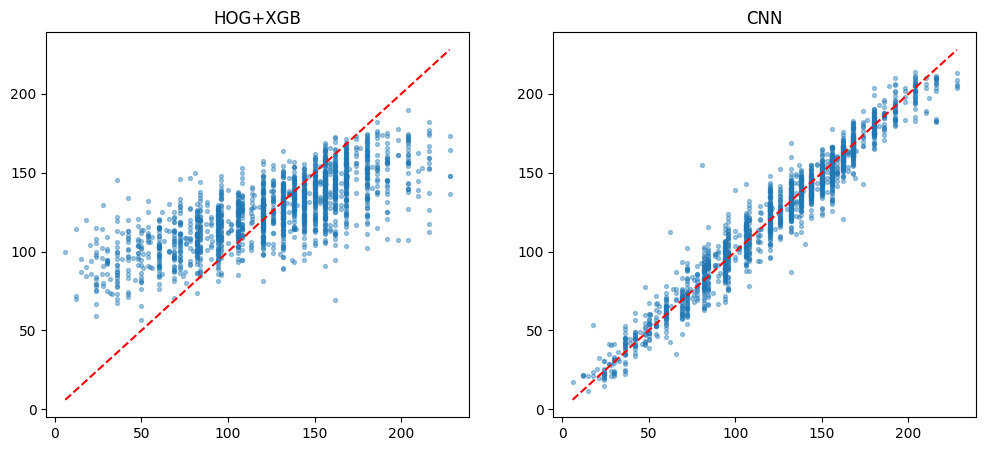

In [17]:
# CELL 16 — Compare HOG vs CNN on validation set
# Build maps of predictions by id for val set
val_ids = val_df.reset_index(drop=True)['id'].values

# CNN preds (iterate val_df)
cnn_preds_map = {}
model.eval()
with torch.no_grad():
    for _, row in tqdm(val_df.reset_index(drop=True).iterrows(), total=len(val_df), desc="CNN val preds"):
        img_id = int(row['id'])
        p = os.path.join(train_img_path, f"{img_id}.png")
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        img = roi_contrast_stretch_gray(img)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img_t = valid_transforms(image=img)['image'].unsqueeze(0).to(DEVICE)
        sex_t = torch.tensor([row['sex_int']], dtype=torch.long).to(DEVICE)
        pred = model(img_t, sex_t).cpu().numpy()[0]
        cnn_preds_map[img_id] = pred

# HOG preds
hog_preds_map = {}
for _, row in tqdm(val_df.reset_index(drop=True).iterrows(), total=len(val_df), desc="HOG val preds"):
    img_id = int(row['id'])
    feat = extract_hog_features(os.path.join(train_img_path, f"{img_id}.png"))
    feat = np.concatenate([feat, np.array([row['sex_int']], dtype=np.float32)])
    feat_s = scaler_hog.transform(feat.reshape(1,-1))
    hog_preds_map[img_id] = xgb_reg.predict(feat_s)[0]

# assemble arrays
y_true_arr, cnn_preds_arr, hog_preds_arr = [], [], []
for _, row in val_df.reset_index(drop=True).iterrows():
    img_id = int(row['id'])
    y_true_arr.append(row['boneage_months'])
    cnn_preds_arr.append(cnn_preds_map[img_id])
    hog_preds_arr.append(hog_preds_map[img_id])

y_true_arr = np.array(y_true_arr)
cnn_preds_arr = np.array(cnn_preds_arr)
hog_preds_arr = np.array(hog_preds_arr)

print("VAL - HOG MAE:", mean_absolute_error(y_true_arr, hog_preds_arr))
print("VAL - CNN MAE:", mean_absolute_error(y_true_arr, cnn_preds_arr))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_true_arr, hog_preds_arr, s=8, alpha=0.4)
plt.title("HOG+XGB")
plt.plot([y_true_arr.min(), y_true_arr.max()], [y_true_arr.min(), y_true_arr.max()], 'r--')

plt.subplot(1,2,2)
plt.scatter(y_true_arr, cnn_preds_arr, s=8, alpha=0.4)
plt.title("CNN")
plt.plot([y_true_arr.min(), y_true_arr.max()], [y_true_arr.min(), y_true_arr.max()], 'r--')
plt.show()


In [ ]:
# FINAL GRAD-CAM + GUIDED BACKPROP + GUIDED GRAD-CAM

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy

# 1) GUIDED RE-LU (for Guided Backprop)
class GuidedReLU(nn.Module):
    def forward(self, x):
        # forward is normal ReLU
        out = F.relu(x)

        # backward only keeps positive gradients
        def backward_hook(module, grad_in, grad_out):
            # mask to keep only positive gradients & activations
            grad = grad_out[0]
            grad = torch.clamp(grad, min=0.0)
            return (grad,)

        out.register_hook(backward_hook)
        return out

def replace_relu_with_guided(model):
    for name, module in model.named_children():
        if isinstance(module, nn.ReLU):
            setattr(model, name, GuidedReLU())
        else:
            replace_relu_with_guided(module)

# 2) Grad-CAM extractor 
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()

        self.gradients = None
        self.activations = None

        def fwd_hook(m, i, o):
            self.activations = o.detach()

        def bwd_hook(m, gi, go):
            self.gradients = go[0].detach()

        target_layer.register_forward_hook(fwd_hook)
        target_layer.register_backward_hook(bwd_hook)

    def generate(self, img_t, sex_t):
        img_t = img_t.to(DEVICE)
        sex_t = sex_t.to(DEVICE)

        out = self.model(img_t, sex_t)
        loss = out.squeeze()
        self.model.zero_grad()
        loss.backward(retain_graph=True)

        # weights = GAP over H,W
        w = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (w * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam[0].cpu().numpy()

# 3) Guided Backprop (uses guided ReLU)
class GuidedBackprop:
    def __init__(self, model):
        self.model = copy.deepcopy(model).eval()
        replace_relu_with_guided(self.model)

    def generate(self, img_t, sex_t):
        img_t = img_t.to(DEVICE).requires_grad_(True)
        sex_t = sex_t.to(DEVICE)

        out = self.model(img_t, sex_t)
        loss = out.squeeze()
        self.model.zero_grad()
        loss.backward()

        grad = img_t.grad[0].detach().cpu().numpy()
        grad = grad.transpose(1,2,0)      # CHW → HWC
        grad = np.maximum(grad, 0)
        grad = grad / (grad.max() + 1e-8)
        return grad

# 4) Utility to visualize
def apply_heatmap_on_image(img_rgb, heatmap):
    heatmap = cv2.resize(heatmap, (img_rgb.shape[1], img_rgb.shape[0]))
    heatmap_color = cv2.applyColorMap((heatmap*255).astype(np.uint8),
                                      cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_rgb, 0.5, heatmap_color, 0.5, 0)
    return overlay

# 5) FULL VISUALIZATION FUNCTION
def visualize_all(img_path, sex="M"):
    # load raw X-ray
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = roi_contrast_stretch_gray(img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # albumentations → tensor
    t = valid_transforms(image=img_rgb)['image'].unsqueeze(0).to(DEVICE)
    s = torch.tensor([1 if sex=='M' else 0], dtype=torch.long).to(DEVICE)

    #  Grad-CAM 
    cam_map = gradcam.generate(t, s)
    cam_overlay = apply_heatmap_on_image(img_rgb, cam_map)

    #  Guided Backprop 
    gb = guided_bp.generate(t, s)

    #  Guided Grad-CAM 
    ggc = gb * cam_map[..., None]
    ggc = ggc / (ggc.max() + 1e-8)

    # show
    plt.figure(figsize=(14,8))
    plt.subplot(1,2,1); plt.imshow(img_rgb, cmap='gray'); plt.title("Original"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(cam_overlay); plt.title("Grad-CAM"); plt.axis('off')
    plt.show()

# INITIALIZE

# Choose last Convolutional block of EfficientNetV2
target_layer = model.backbone.blocks[-1][-1].conv_dw

gradcam = GradCAM(model, target_layer)
guided_bp = GuidedBackprop(model)


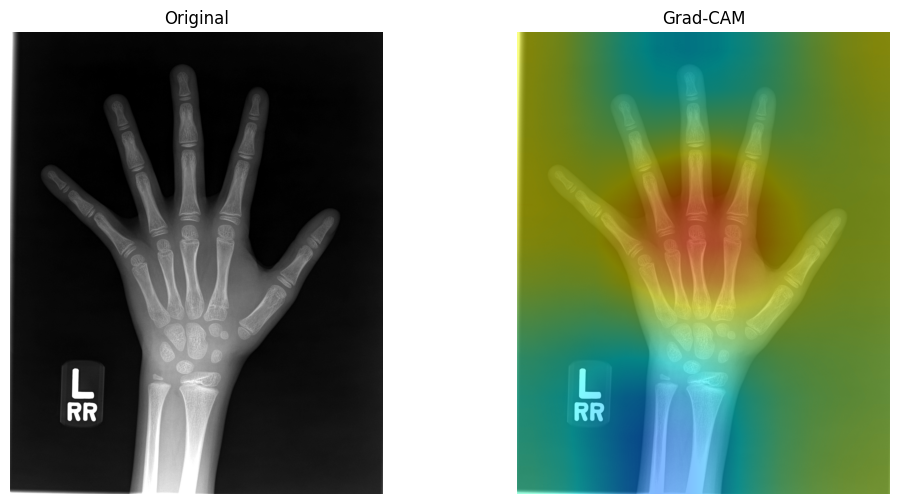

In [ ]:
# Example
cam = GradCAM(model, target_layer)
show_gradcam(f"{train_img_path}/10000.png", "M")


In [18]:
# CELL 17 — Gender-wise error analysis (validation)
val_df2 = val_df.reset_index(drop=True).copy()
val_df2['cnn_pred'] = val_df2['id'].map(cnn_preds_map)
val_df2['hog_pred'] = val_df2['id'].map(hog_preds_map)

for sex_val, label in [(1,'Male'),(0,'Female')]:
    sub = val_df2[val_df2['sex_int']==sex_val]
    print(f"{label}  (n={len(sub)})  CNN MAE: {mean_absolute_error(sub['boneage_months'], sub['cnn_pred']):.3f}  HOG MAE: {mean_absolute_error(sub['boneage_months'], sub['hog_pred']):.3f}")


Male  (n=1025)  CNN MAE: 6.770  HOG MAE: 24.258
Female  (n=867)  CNN MAE: 7.189  HOG MAE: 23.107


In [ ]:
# CELL 18— Predict Kaggle test set (CNN regression)

tst = test_csv.copy()

# standardize CSV columns
if 'Case ID' in tst.columns:
    tst = tst.rename(columns={'Case ID': 'id'})

# map to ints for model, but store M/F later
if 'Sex' in tst.columns:
    tst['sex_int'] = tst['Sex'].map({'M': 1, 'F': 0}).astype(int)
else:
    raise RuntimeError("Test CSV missing 'Sex' column")

if 'id' not in tst.columns:
    raise RuntimeError("Test CSV missing 'id' column")

pred_rows = []
model.eval()

with torch.no_grad():
    for _, row in tqdm(tst.iterrows(), total=len(tst), desc="Predicting Kaggle test (CNN)"):
        img_id = int(row['id'])
        p = os.path.join(test_img_path, f"{img_id}.png")

        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        img = roi_contrast_stretch_gray(img)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        img_t = valid_transforms(image=img)['image'].unsqueeze(0).to(DEVICE)
        sex_t = torch.tensor([row['sex_int']], dtype=torch.long).to(DEVICE)

        pred = model(img_t, sex_t).cpu().numpy()[0]

        pred_rows.append({
            "id": img_id,
            "sex": "M" if row["sex_int"] == 1 else "F",    
            "pred_boneage_months": float(pred)
        })

pred_df = pd.DataFrame(pred_rows)
pred_df.to_csv("cnn_test_predictions.csv", index=False)
pred_df.head()

Predicting Kaggle test (CNN):   0%|          | 0/200 [00:00<?, ?it/s]

,id,sex,pred_boneage_months
0,4360,M,174.294479
1,4361,M,167.970367
2,4362,M,72.808609
3,4363,M,144.507843
4,4364,M,134.382584
